In [2]:
%load_ext autoreload
%autoreload 0

In [3]:
from functools import partial

import gymnasium as gym
import numpy as np
import seaborn as sns
import torch as t
from gymnasium import wrappers
from gymnasium.envs.registration import EnvSpec
from matplotlib import pyplot as plt
from rich.pretty import pprint as pp
from tqdm import tqdm

from bert_sac.models import Actor, SoftQNetwork
from bert_sac.sac_trainer import AntSAC, AntSACConfig
from bert_sac.utils import make_env

ppe = partial(pp, expand_all=True)

SEED = 999

device = t.device("cuda:0")
t.set_default_device(device)

ModuleNotFoundError: No module named 'bert_sac.utils'

In [ ]:
att_mask = [
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 7 + [0] * 6 + [1] * 8 + [0] * 6,
    [1] * 5 + [0] * 2 + [1] * 2 + [0] * 4 + [1] * 6 + [0] * 2 + [1] * 2 + [0] * 4,
    [1] * 5 + [0] * 4 + [1] * 2 + [0] * 2 + [1] * 6 + [0] * 4 + [1] * 2 + [0] * 2,
    [1] * 5 + [0] * 6 + [1] * 2 + [0] * 0 + [1] * 6 + [0] * 6 + [1] * 2 + [0] * 0,
    [0] * 5 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 6,
    [0] * 7 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 4,
    [0] * 9 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 2,
    [0] * 11 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 0,
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 7 + [0] * 6 + [1] * 8 + [0] * 6,
    [1] * 5 + [0] * 2 + [1] * 2 + [0] * 4 + [1] * 6 + [0] * 2 + [1] * 2 + [0] * 4,
    [1] * 5 + [0] * 4 + [1] * 2 + [0] * 2 + [1] * 6 + [0] * 4 + [1] * 2 + [0] * 2,
    [1] * 5 + [0] * 6 + [1] * 2 + [0] * 0 + [1] * 6 + [0] * 6 + [1] * 2 + [0] * 0,
    [0] * 5 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 6,
    [0] * 7 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 4,
    [0] * 9 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 2,
    [0] * 11 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 0,
]

In [6]:
att_mask = [
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 7 + [0] * 6 + [1] * 8 + [0] * 6, # бедро1
    [0] * 5 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 6, # колено1
    [1] * 5 + [0, 0, 1, 1] + [0] * 4 + [1] * 6 + [0, 0, 1, 1] + [0] * 4, # бедро2
    [0] * 5 + [0, 0, 1, 1] + [0] * 12 + [1] * 2 + [0] * 4, # колено2
    [1] * 5 + [0] * 4 + [1, 1, 0, 0] + [1] * 6 + [0] * 4 + [1, 1, 0, 0], # бедро3
    [0] * 9 + [1, 1] + [0] * 12 + [1] * 2 + [0] * 2, # колено3
    [1] * 5 + [0] * 6 + [1] * 8 + [0] * 6 + [1, 1], # бедро4
    [0] * 11 + [1, 1] + [0] * 12 + [1] * 2, # колено4
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 7 + [0] * 6 + [1] * 8 + [0] * 6, # бедро1
    [0] * 5 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 6, # колено1
    [1] * 5 + [0, 0, 1, 1] + [0] * 4 + [1] * 6 + [0, 0, 1, 1] + [0] * 4, # бедро2
    [0] * 5 + [0, 0, 1, 1] + [0] * 12 + [1] * 2 + [0] * 4, # колено2
    [1] * 5 + [0] * 4 + [1, 1, 0, 0] + [1] * 6 + [0] * 4 + [1, 1, 0, 0], # бедро3
    [0] * 9 + [1, 1] + [0] * 12 + [1] * 2 + [0] * 2, # колено3
    [1] * 5 + [0] * 6 + [1] * 8 + [0] * 6 + [1, 1], # бедро4
    [0] * 11 + [1, 1] + [0] * 12 + [1] * 2, # колено4
]
np.array(att_mask)

array([[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 0],
       [0, 0, 0, 0, 

{'ATT_MASK.shape': torch.Size([27, 27])}

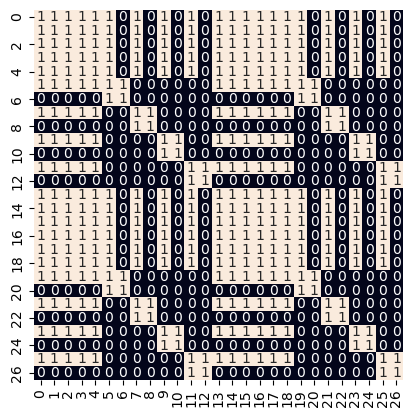

In [7]:
NUM_STRUCT_ELEMENTS = 7

ATT_MASK = t.tensor(
    [[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1]]
)

pp({"ATT_MASK.shape": ATT_MASK.shape})

sns.heatmap(ATT_MASK.cpu(), square=True, cbar=False, annot=True)
plt.show()

In [7]:
import gym_ants

In [8]:
envs = gym.vector.AsyncVectorEnv([make_env("manylegs/ants_3_legs", seed=SEED) for _ in range(4)])

In [9]:
envs.observation_space, envs.action_space

(Box(-inf, inf, (4, 23), float64), Box(-1.0, 1.0, (4, 6), float32))

In [12]:
sac_config = AntSACConfig(n_legs=3, seed=SEED, checkpoint_frequency=20_000)
sac = AntSAC(
    actor_net=Actor,
    critic_net=SoftQNetwork,
    envs=envs,
    num_obs=envs.single_observation_space.shape[0], # type: ignore
    num_act=envs.single_action_space.shape[0], # type: ignore
    device=device,
    attention_mask=ATT_MASK,
    config=sac_config,
    artifact_path="./artifacts",
    num_att_layers=3,
)
  
sac.global_step

0

In [13]:
import warnings

warnings.filterwarnings("ignore")

sac.train(500_000)

100%|██████████| 500000/500000 [3:56:29<00:00, 35.24it/s]  
